In [1]:
import glob
import numpy  as np
import tables as tb

import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# general IC imports
from invisible_cities.database          import load_db
from invisible_cities.core.system_of_units_c import units
adc, pes, mus = units.adc, units.pes, units.mus
NN = -999999

# IRENE
from invisible_cities.cities.components import deconv_pmt
from invisible_cities.cities.components import calibrate_pmts
from invisible_cities.cities.components import calibrate_sipms

from invisible_cities.cities.components import deconv_pmt
from invisible_cities.cities.components import calibrate_pmts
from invisible_cities.cities.components import calibrate_sipms
from invisible_cities.cities.components import zero_suppress_wfs

from invisible_cities.reco.peak_functions import split_in_peaks
from invisible_cities.reco.peak_functions import select_peaks
from invisible_cities.reco.peak_functions import select_wfs_above_time_integrated_thr
from invisible_cities.reco.peak_functions import pick_slice_and_rebin

from invisible_cities.types.ic_types import minmax

# PENTHESILEA
from invisible_cities.reco.peak_functions import rebin_times_and_waveforms

# ESMERALDA
from invisible_cities.reco.corrections_new import read_maps
from invisible_cities.reco.corrections_new import apply_all_correction
from invisible_cities.reco.corrections_new import norm_strategy

## General cut parameters

In [2]:
# S1 selection
s1emin = 40
s1wmin = 175

pmt_ids = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

## Import raw waveforms

In [3]:
run = 7430
wfs_dir        = f"/home/gdiaz/Verify_IRENENB_corrections/DATA/{run}/rwf/"
wfs_files = glob.glob( wfs_dir + "/*" )
wfs_files.sort()

# IRENE

## Configuration Parameters

In [4]:
files_in  = wfs_files
file_out  = ""

run = 7430
n_baseline = 62400 

n_mau   = 100
thr_mau =   3 * adc

thr_csum_s1 = 0.5 * pes
thr_csum_s2 = 2.0 * pes

thr_sipm   = 1.0 * pes    
thr_sipm_type = "Common"

s1_tmin   =   0 * mus 
s1_tmax   = 790 * mus 
s1_stride =   4       
s1_lmin   =   5       
s1_lmax   =  30      
s1_rebin_stride = 1

s2_tmin   =      0 * mus 
s2_tmax   =   1601 * mus 
s2_stride =     40      
s2_lmin   =     80       
s2_lmax   = 200000       
s2_rebin_stride = 40   

thr_sipm_s2 = 5 * pes  

detector_db = "new" ## Added by me

if thr_sipm_type.lower() == "common": 
    sipm_thr = thr_sipm

### Select file and waveform

In [5]:
file_number = 0

RWFs_file = tb.open_file(files_in[file_number])
pmt_rwfs_all  = RWFs_file.root.RD.pmtrwf
sipm_rwfs_all = RWFs_file.root.RD.sipmrwf
time_stamps   = RWFs_file.root.Run.events

#select random waveform
i = int( np.random.random()* (len(time_stamps) - 1) )
event_time = time_stamps[i]


pmt_rwfs  = pmt_rwfs_all [i]
sipm_rwfs = sipm_rwfs_all[i]

RWFs_file.close()

### Sensors processing

In [6]:
rwf_to_cwf = deconv_pmt    (detector_db, run, n_baseline)
pmt_cwfs   = rwf_to_cwf    (pmt_rwfs)
cwf_to_ccwf = calibrate_pmts(detector_db, run, n_mau, thr_mau)
pmt_ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau  = cwf_to_ccwf    (pmt_cwfs)

sipm_rwf_to_cal = calibrate_sipms(detector_db, run, sipm_thr)
sipm_cwfs = sipm_rwf_to_cal(sipm_rwfs)

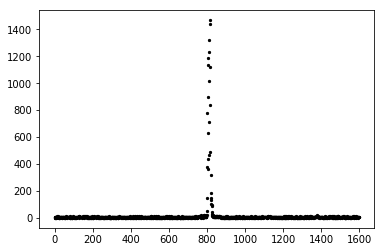

In [7]:
times = np.arange(sipm_cwfs.shape[1])
plt.scatter(times, np.sum( sipm_cwfs, axis=0), color="black", s=5 )

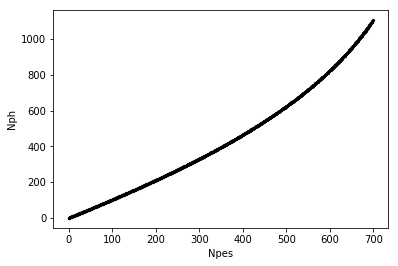

In [8]:
params = np.array( [ 6.58477685e-22,  1.50455111e-17, -2.74129372e-14,  2.03138072e-11,
                    -7.13216271e-09,  1.83113819e-06,  4.85324372e-05,  1.00393735e+00,
                    -1.89564238e-02] )
params = np.flip(params)

def pes_to_photons(Npes):
    #polynomial correction
    exp = np.array( [Npes**i for i in range(0, 9)] )
    Nph = np.sum( np.multiply(params, exp.T).T, axis=0)
    
    #identity correction
    sel = Npes<50
    Nph[sel] = Npes[sel]
    
    return Nph

Npes = np.arange(0, 700, dtype=np.float)
Nph = pes_to_photons(Npes)

plt.scatter( Npes, Nph, c="black", s=5)
plt.xlabel("Npes")
plt.ylabel("Nph");

In [9]:
corrsipm = pes_to_photons(sipm_cwfs)

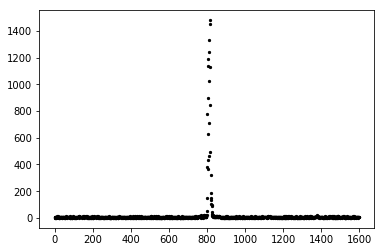

In [10]:
times = np.arange(sipm_cwfs.shape[1])
plt.scatter(times, np.sum( corrsipm, axis=0), color="black", s=5 )

### Find S1 and S2 peaks (IRENE)

In [11]:
zero_suppress = zero_suppress_wfs(thr_csum_s1, thr_csum_s2)
s1_indices, s2_indices = zero_suppress(cwf_sum, cwf_sum_mau)

indices_split   = split_in_peaks(s1_indices, s1_stride)
time    = minmax(min = s1_tmin, max = s1_tmax)
length  = minmax(min = s1_lmin, max = s1_lmax)
s1_selected_splits = select_peaks  (indices_split, time, length)
print("Number of S1 candidates:", len(s1_selected_splits))


indices_split   = split_in_peaks(s2_indices, s2_stride)
time    = minmax(min = s2_tmin, max = s2_tmax)
length  = minmax(min = s2_lmin, max = s2_lmax)
s2_selected_splits = select_peaks  (indices_split, time, length)
print("Number of S2 candidates:", len(s2_selected_splits))

Number of S1 candidates: 1
Number of S2 candidates: 1


### S1 and S2 cuts

In [12]:
# S1 cuts
if len(s1_selected_splits)==0:
    raise Exception("No S1 in event")
    
s1es, s1ws = [], []
for ss in s1_selected_splits:
    s1_pmt = np.sum( pmt_ccwfs[:, ss[0]: ss[-1]], axis=0)
    s1es.append( np.sum(s1_pmt)    )
    s1ws.append( (ss[-1]-ss[0])*25 )
s1es, s1ws = np.array(s1es), np.array(s1ws)

sel = (s1es>=s1emin) & (s1ws>=s1wmin)
idxs = np.argwhere(sel).flatten()

if len(idxs)==0:
    raise Exception("No S1 pass the cut")
elif len(idxs)>1:
    raise Exception("More than 1S1 pass the cut")
else:
    idx = idxs[0]
    s1_pmt = np.sum( pmt_ccwfs[:, s1_selected_splits[idx][0]: s1_selected_splits[idx][-1]], axis=0)
    times  = np.arange(s1_selected_splits[idx][0], s1_selected_splits[idx][-1])*25

    S1_time = times[np.argmax(s1_pmt)]
    
# S2 cut
if len(s2_selected_splits)>1:
    raise Exception("More that 1S2")

### Select and process S2 RWFs

In [13]:
times  = np.arange     (pmt_ccwfs.shape[1]) * 25 * units.ns
widths = np.full       (pmt_ccwfs.shape[1],   25 * units.ns)

indices = s2_selected_splits[0]
wfs     = pmt_ccwfs

with_sipms = True

times, rebinned_widths, s2_pmts = pick_slice_and_rebin(indices, times, widths,
                                                       wfs, 
                                                       rebin_stride = s2_rebin_stride, 
                                                       pad_zeros    = with_sipms)

In [14]:
s2_sipms = sipm_cwfs[:, s2_selected_splits[0][0] //40 : s2_selected_splits[0][-1]//40 + 1]


########## ADD PES TO PHOTON CONVERSION HERE ############
s2_sipms = pes_to_photons(s2_sipms)


# thr_sipm_s2
sipm_ids, s2_sipms = select_wfs_above_time_integrated_thr(s2_sipms, thr_sipm_s2)



#float32
s2_pmts  = np.float32( s2_pmts )
s2_sipms = np.float32( s2_sipms)
times    = np.float32( times   )

#pmt ids
c = np.zeros(s2_pmts.shape[0])
c[pmt_ids] = 1
s2_pmts  = np.multiply( c, s2_pmts.T ).T

## PENTHESILEA

## Rebin

In [15]:
# Rebin
rebin = 2

_, _, s2_sipms    = rebin_times_and_waveforms(times, rebinned_widths, s2_sipms,
                                              rebin_stride=rebin, slices=None)

times, _, s2_pmts = rebin_times_and_waveforms(times, rebinned_widths, s2_pmts,
                                              rebin_stride=rebin, slices=None)

In [16]:
s2_pmts_penth  = np.copy( s2_pmts )
s2_sipms_penth = np.copy( s2_sipms )

## Create hits

In [17]:
datasipm = load_db.DataSiPM("new", run)
sipm_xs  = datasipm.X.values
sipm_ys  = datasipm.Y.values
n_sipms = len(sipm_ids)

X, Y = sipm_xs[sipm_ids], sipm_ys[sipm_ids]
T = (times - S1_time)/1000

In [18]:
E_per_slice = np.sum( s2_pmts_penth, axis=0)

hits = []
for t, e, q in zip(T, E_per_slice, s2_sipms_penth.T):
    hits.append( (X, Y, np.full( n_sipms, t), 
                  np.full(n_sipms, e), np.full( n_sipms, -1), 
                  q                  , np.full( n_sipms, -1) ) )

hits = np.array( hits )
hits = np.swapaxes(hits, axis1=1, axis2=2)
hits = np.concatenate( hits )

In [19]:
H = np.array(np.zeros(np.shape(hits)[0]), 
             dtype=[("X", int)  , ("Y", int)  , ("Z", float), 
                    ("E", float), ("Ec",float),
                    ("Q", float), ("Qc", float)])

H["X"], H["Y"], H["Z"] = hits[:, 0], hits[:, 1], hits[:, 2]
H["E"], H["Ec"] = hits[:, 3], -1                            #OJO, la energía del hit es la energia de la slice
H["Q"], H["Qc"] = hits[:, 5], -1

#remove 0 charge hits
sel = ~(H["Q"]==0)
hits = H[sel]

## Charge Corrections

In [25]:
from invisible_cities.reco.corrections_new import correct_lifetime_
from invisible_cities.reco.corrections_new import maps_coefficient_getter

qmap_file = glob.glob( f"/home/gdiaz/SIPM_correction/data/maps/qmap_*")[0]
qmaps = read_maps( qmap_file )

# total_correction = apply_all_correction(maps, apply_temp=True,
#                                         norm_strat=norm_strategy.kr)

get_lt_corr_fun = maps_coefficient_getter(qmaps.mapinfo, qmaps.lt)
apply_temp=False
if apply_temp:
    raise Exception("Apply temp is False")
else:
    ltevol_vs_t = lambda x : np.ones_like(x)

In [26]:
X, Y, Z = hits["X"], hits["Y"], hits["Z"]
Q = hits["Q"]
T = np.full(len(hits), event_time[-1]/1000)

lt_factor  = correct_lifetime_(Z, get_lt_corr_fun(X, Y) * ltevol_vs_t(T))
Qc = lt_factor * Q

hits["Qc"] = Qc

In [27]:
hits

array([(-95,   65, 220.76814419, 243.67616241, -1., 1.01528907, 1.07625228),
       (-95,   75, 220.76814419, 243.67616241, -1., 3.4644227 , 3.70196777),
       (-95,   85, 220.76814419, 243.67616241, -1., 1.03783739, 1.10293007),
       ...,
       (-35, -205, 249.85264983, 183.95663929, -1., 1.73095393,        nan),
       ( 25,  145, 249.85264983, 183.95663929, -1., 1.02345324, 1.11123749),
       ( 55,  -65, 249.85264983, 183.95663929, -1., 3.77339077, 4.0274281 )],
      dtype=[('X', '<i8'), ('Y', '<i8'), ('Z', '<f8'), ('E', '<f8'), ('Ec', '<f8'), ('Q', '<f8'), ('Qc', '<f8')])

## Charge cut

In [28]:
qth_penth = 30 * pes

In [29]:
qth = qth_penth

sel = (hits["Qc"]>=qth)
hits["Qc"][~sel] = 0

slides = np.unique( hits["Z"] )
for slide in slides:
    sel = (hits["Z"]==slide)
    slide_hits = hits[sel]
    
    q = slide_hits["Qc"]
    e = slide_hits["E"]
    slide_e = e[0]     ## OJO AQUÍ   

    if np.sum( q ) == 0:
        idxs = np.argwhere(sel).flatten()
        hits = np.delete(hits, idxs)
        hits = np.insert(hits, 0, (0, 0, slide, 
                                   slide_e, NN, 
                                   NN, NN))
    else:
        hits["E"][sel] = slide_e * q / np.sum(q)
        
sel = (hits["Qc"]==0)
hits = np.delete( hits, np.argwhere(sel))
hits = np.sort(hits, order="Z")

In [30]:
hits

array([(   0,    0, 220.76814419,  243.67616241, -9.99999e+05, -9.99999000e+05, -9.99999000e+05),
       (  45, -155, 222.61535583, 2311.63030784, -1.00000e+00,  6.98657074e+01,  7.34251258e+01),
       (  55, -155, 222.61535583, 1348.9965728 , -1.00000e+00,  3.98736954e+01,  4.28486522e+01),
       ( -95,   75, 224.43119066, 1000.54737644, -1.00000e+00,  4.98988571e+01,  5.33789765e+01),
       ( -85,   65, 224.43119066,  765.65747753, -1.00000e+00,  3.84982338e+01,  4.08476535e+01),
       ( -85,   75, 224.43119066, 1339.80667113, -1.00000e+00,  6.72820892e+01,  7.14783833e+01),
       ( -85,   85, 224.43119066,  733.8903032 , -1.00000e+00,  3.68904190e+01,  3.91528819e+01),
       (  35, -165, 224.43119066,  591.93830042, -1.00000e+00,  2.96493206e+01,  3.15797746e+01),
       (  35, -155, 224.43119066,  656.95783392, -1.00000e+00,  3.29227676e+01,  3.50485520e+01),
       (  45, -165, 224.43119066, 1486.32567921, -1.00000e+00,  7.50225601e+01,  7.92951392e+01),
       (  45, -155, 

In [31]:
# JOIN NN hits

sel = (hits["Q"]==NN)

nn_hits = hits[ sel]
hits    = hits[~sel]

slides = np.unique( hits["Z"] )

for nn_hit in nn_hits:
    
    #select slide to append
    d = np.abs( slides - nn_hit["Z"] ) 
    
    slide = slides[ np.argmin( d ) ]
    slide_hits = hits[hits["Z"]==slide]
    
    #new energy 
    new_E = np.sum(slide_hits["E"]) + nn_hit["E"]
    
    q = hits[hits["Z"]==slide]["Q"]
    Q = np.sum( q )
    
    hits["E"][hits["Z"] == slide] = new_E * q / Q

In [32]:
hits

array([(  45, -155, 222.61535583, 2485.67868158, -1.,  69.8657074 ,  73.42512584),
       (  55, -155, 222.61535583, 1418.62436147, -1.,  39.87369537,  42.84865222),
       ( -95,   75, 224.43119066, 1000.54737644, -1.,  49.89885712,  53.37897652),
       ( -85,   65, 224.43119066,  765.65747753, -1.,  38.4982338 ,  40.84765347),
       ( -85,   75, 224.43119066, 1339.80667113, -1.,  67.28208923,  71.47838326),
       ( -85,   85, 224.43119066,  733.8903032 , -1.,  36.89041901,  39.1528819 ),
       (  35, -165, 224.43119066,  591.93830042, -1.,  29.6493206 ,  31.57977461),
       (  35, -155, 224.43119066,  656.95783392, -1.,  32.92276764,  35.04855204),
       (  45, -165, 224.43119066, 1486.32567921, -1.,  75.02256012,  79.29513924),
       (  45, -155, 224.43119066, 3196.48324932, -1., 162.19906616, 170.5316593 ),
       (  45, -145, 224.43119066, 1295.50649237, -1.,  64.49584961,  69.11497873),
       (  55, -165, 224.43119066, 1208.75498821, -1.,  61.3635025 ,  64.48680558),
    